In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def f(x):
    return x**2 + 4*x + 7

In [3]:
f(3)

28

-3.75
6.0625


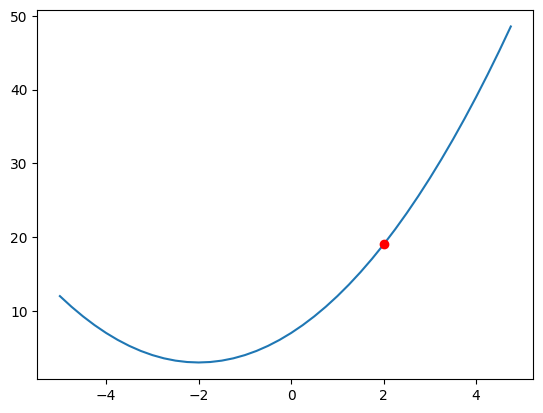

In [4]:
xs = np.arange(-5, 5, .25)
ys = f(xs)
print(xs[5])
print(ys[5])
plt.plot(xs, ys)
a = f(2)
plt.plot(2, a, 'ro')

In [5]:
from graphviz import Digraph

def trace(root):
    # builds a set of all nodes and edges in a graph
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root):
    dot = Digraph(format='svg', graph_attr = {'rankdir': 'LR'}) #LR c-a-d left to right
    nodes, edges = trace(root)
    
    for n in nodes:
        uid = str(id(n))
        
        dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
        if n._op:
            
        # for any value in the graph, create a rectanular node for it
        
            dot.node(name = uid + n._op, label = n._op)

            # connect node to it

            dot.edge(uid + n._op, uid)

    for n1, n2 in edges:
        # connect n1 to the op node of n2
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
        
    return dot

        
    

In [48]:
class Value:
    def __init__(self, data, _children=(), _op='', label=""):
        self.data = data
        self.grad = 0.0
        self._backward = lambda : None
        self._prev = set(_children)
        self._op = _op
        self.label = label
        
    def __repr__(self):
        return f"Value data={self.data}"
    
    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')
        
        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        out._backward = _backward
        return out
    
    def __sub__(self, other):
        return self + (-other)
    
    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')

        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward
        
        
        return out
    
    
    def __truediv__(self, other):
        return self * other**-1
    
    def __pow__(self, other):
        assert isinstance(other, (int, float)), "only supporting int"
        out = Value(self.data**other, (self,), f'**{other}')
        
        def _backward():
            self.grad += (other * self.data ** other - 1) * out.grad
        out._backward = _backward
        
    def __neg__(self):
        return self * -1
        
    
    
    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self, ), 'exp')

        def _backward():
            self.grad += out.data * out.grad
        out._backward = _backward
        
        
        return out
    
    def __rmul__(self, other):
        return self * other
    
    
    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
        out = Value(t, (self, ), 'tanh')
        
        def _backward():
            self.grad += (1 - t**2) * out.grad
        out._backward = _backward
        
        
        return out
    
    def backward(self):
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)

        self.grad = 1.0

        for node in reversed(topo):
            node._backward()

    
    

a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')
e = a*b; e.label = 'e'
d = e + c; d.label = 'd'
f = Value(-2.0, label='f')
L = d * f; L.label = 'L'


In [49]:
a.grad = -2.0 * -3.0
b.grad = -2.0 * -3.0
L.grad = 1.0
f.grad = 4.0
d.grad = -2.0
c.grad = d.grad
e.grad =  d.grad

In [50]:
a.data += 0.01 * a.grad
b.data += 0.01 * b.grad
c.data += 0.01 * c.grad
f.data += 0.01 * f.grad

e = a * b
d = e + c
L = d * f

print(L.data)


-7.690256000000001


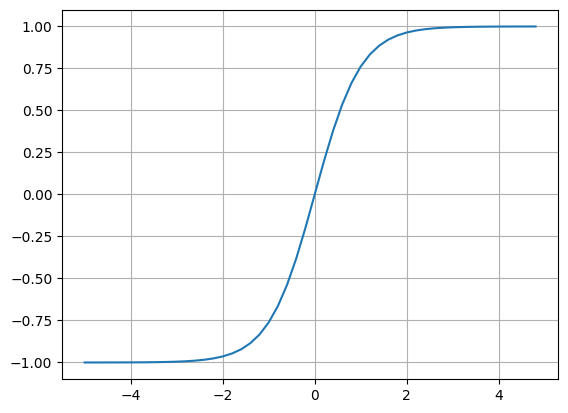

In [51]:
plt.plot(np.arange(-5,5,.2), np.tanh(np.arange(-5, 5, .2))); plt.grid();

In [ ]:
# inputs
x1 = Value(2, label='x1')
x2 = Value(0, label='x2')

#weights
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

#bias of the neuron
b = Value(6.88137, label='b')

x1w1 = x1*w1; x1w1.label = 'x1w1'
x2w2 = x2*w2; x2w2.label = 'x2w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1w1x2w2'
n = x1w1x2w2 + b; n.label = 'n'

e = (2*n).exp()
o = (e -1) /  (e + 1)

o = o.label = 'o'


In [53]:
# manually setting gradients
# n.grad = 1 - o.data**2
# o.grad = 1
# x1w1x2w2.grad = n.grad
# b.grad = n.grad
# x1w1.grad = n.grad
# x2w2.grad = n.grad

# w1.grad = x1.data * x1w1.grad
# w2.grad = x2.data * x2w2.grad

# x1.grad = w1.data * x1w1.grad
# x2.grad = w2.data * x2w2.grad

In [54]:
o.backward()
# manually setting values before using loop to do it
# n._backward()
# b._backward()
# x1w1x2w2._backward()
# x2w2._backward()
# x1w1._backward()


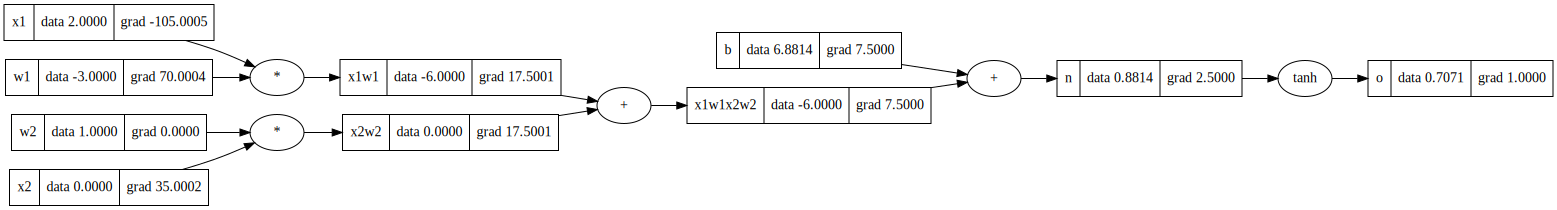

In [55]:
draw_dot(o)

In [6]:
import torch

x1 = torch.Tensor([2.0]).double() ;   x1.requires_grad = True
x2 = torch.Tensor([0.0]).double() ;   x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double() ;  w1.requires_grad = True
w2 = torch.Tensor([1.0]).double() ;   w2.requires_grad = True
b = torch.Tensor([6.8814]).double() ; b.requires_grad = True
n = x1*w1 + x2*w2 + b

o = torch.tanh(n)
print(o.data.item())
o.backward()

print('----')
print('x1', x1.grad.item())
print('x2', x2.grad.item())
print('w1', w1.grad.item())
print('w2', w2.grad.item())



0.7071200415967962
----
x1 -1.4999437403164355
x2 0.49998124677214517
w1 0.9999624935442903
w2 0.0


tensor([0.7071], dtype=torch.float64, grad_fn=<TanhBackward0>)